Loaded df from breastCancer.csv
Using target column: class
Original unique target values: [2 4]
Mapped {2,4} -> {0,1}
Final label set: [0 1]
numeric_cols: 9  categorical_cols: 1
Processed X shape: (699, 20)
Train/test shapes: (559, 20) (140, 20)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV score (on train folds): 0.9678088803088803

Test accuracy: 0.9643

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97        92
           1       0.92      0.98      0.95        48

    accuracy                           0.96       140
   macro avg       0.96      0.97      0.96       140
weighted avg       0.97      0.96      0.96       140



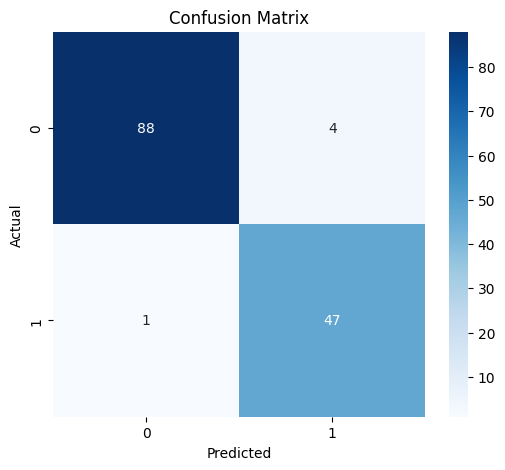

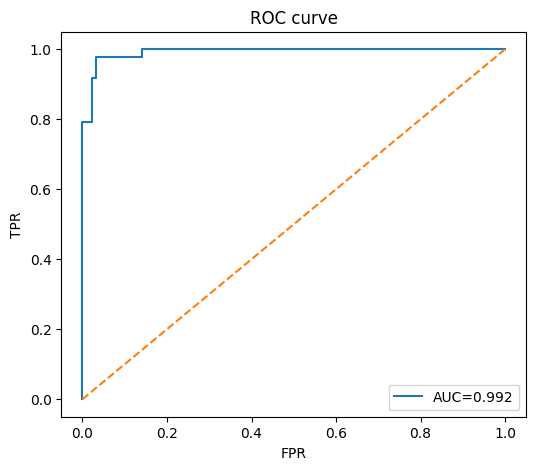

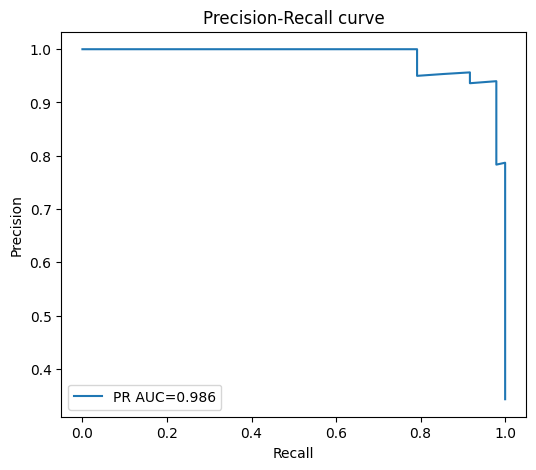

CV accuracy mean/std: 0.9642 / 0.0136
CV ROC AUC mean/std: 0.9902 / 0.0053


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc

# --- Load df if not present (adjust path if needed)
csv_path = 'breastCancer.csv'   # change if needed
df = pd.read_csv(csv_path)
print("Loaded df from", csv_path)

# --- Detect target column (same heuristic used previously)
possible_targets = [c for c in df.columns if c.lower() in ('target','label','diagnosis','diagnosis_label','class')]
target_col = possible_targets[0] if len(possible_targets)==1 else df.columns[-1]
print("Using target column:", target_col)

X = df.drop(columns=[target_col]).copy()
y_raw = df[target_col].copy()

# --- Force mapping to 0/1
uniq = np.unique(y_raw)
print("Original unique target values:", uniq)

if set(uniq) == {2, 4}:
    y = pd.Series(y_raw).map({2:0, 4:1}).values
    print("Mapped {2,4} -> {0,1}")
elif (pd.api.types.is_object_dtype(y_raw) or pd.api.types.is_categorical_dtype(y_raw)) and len(uniq)==2:
    # e.g., 'M'/'B' -> factorize
    y = pd.factorize(y_raw)[0]
    print("Factorized string labels -> ints")
elif len(uniq)==2 and set(uniq) != {0,1}:
    # numeric pair like {1,2} -> map smallest->0 largest->1
    mapping = {uniq[0]:0, uniq[1]:1}
    y = pd.Series(y_raw).map(mapping).values
    print(f"Mapped numeric labels {tuple(uniq)} -> (0,1) using mapping {mapping}")
else:
    # assume already 0/1 or multi-class; fall back to factorize if non-numeric multi-class
    if pd.api.types.is_numeric_dtype(y_raw) and set(uniq).issubset({0,1}):
        y = y_raw.values
        print("Labels already 0/1.")
    else:
        # fallback: factorize whatever they are (multi-class becomes 0..k-1)
        y = pd.factorize(y_raw)[0]
        print("Fallback: factorized labels to integers. New unique:", np.unique(y))

print("Final label set:", np.unique(y))

# --- Preprocessing: build a fresh preprocessor to avoid cross-cell stale objects
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
print('numeric_cols:', len(numeric_cols), ' categorical_cols:', len(categorical_cols))

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_cols),
                                               ('cat', categorical_transformer, categorical_cols)])

X_processed = preprocessor.fit_transform(X)
print("Processed X shape:", X_processed.shape)

# --- Split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print("Train/test shapes:", X_train.shape, X_test.shape)

# --- GridSearchCV for SVM
param_grid = [
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
    {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10]}
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(SVC(probability=True), param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
best = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV score (on train folds):", grid.best_score_)

# --- Evaluation on test set
y_pred = best.predict(X_test)
if hasattr(best, "predict_proba"):
    y_score = best.predict_proba(X_test)[:, 1]
else:
    try:
        df_scores = best.decision_function(X_test)
        y_score = (df_scores - df_scores.min()) / (df_scores.max() - df_scores.min())
    except:
        y_score = y_pred  # fallback

acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy: {:.4f}".format(acc))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC & PR (only valid / meaningful for binary)
if len(np.unique(y)) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_score)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--')
    plt.title('ROC curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

    prec, rec, _ = precision_recall_curve(y_test, y_score, pos_label=1)
    pr_auc = auc(rec, prec)
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, label=f'PR AUC={pr_auc:.3f}')
    plt.title('Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
else:
    print("Target is not binary, skipping ROC/PR plots.")

# --- Cross-validated metrics on full dataset (optional)
cv_acc = cross_val_score(best, preprocessor.transform(X), y, cv=cv, scoring='accuracy', n_jobs=-1)
print("CV accuracy mean/std: {:.4f} / {:.4f}".format(cv_acc.mean(), cv_acc.std()))
if len(np.unique(y))==2:
    cv_roc = cross_val_score(best, preprocessor.transform(X), y, cv=cv, scoring='roc_auc', n_jobs=-1)
    print("CV ROC AUC mean/std: {:.4f} / {:.4f}".format(cv_roc.mean(), cv_roc.std()))
